Make a chart showing the running total of fatality crashes by year. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib._color_data import BASE_COLORS, TABLEAU_COLORS, CSS4_COLORS, XKCD_COLORS

In [2]:
from crash_data_analysis import CrashDataAnalysis

In [3]:
cda = CrashDataAnalysis()
df = cda.crash_dataframe(verbose=True)

Reading file: data/denver_crashes_2022_04_24__12_01.csv
Max timestamp: 2022-04-22 18:36:00


In [4]:
# Aggregate fatality crashes by year and day of year

crashes_by_day_of_year = pd.pivot_table(
    data=df
    , values='fatality'
    # , values='sbi_or_fatality'
    # , values='one'
    , index='crash_day_of_year'
    , columns='crash_year'
    , aggfunc='sum'
    , fill_value=None
    )

running_total_crashes = crashes_by_day_of_year.cumsum()

max_day_of_year = df.reported_date.max().day_of_year

In [5]:
# Determine the number of days in each year. 365 normally, 366 for leap years

days_in_year = pd.Series(index=sorted(df.crash_year.unique()), dtype=int)

for year in sorted(df.crash_year.unique()):
    
    if year == 2022:
        days_in_year.loc[year] = max_day_of_year

    else:
        days_in_year.loc[year] = pd.Timestamp(year, 12, 31).dayofyear

In [6]:
# Make DataFrame with info about every month

first_of_month = pd.DataFrame({'month_int': range(1,13)})
first_of_month['month_str'] = first_of_month.apply(
    lambda row: pd.Timestamp(2022, row.month_int, 1).strftime('%b'), axis=1)
first_of_month['day_of_year'] = first_of_month.apply(
    lambda row: pd.Timestamp(2022, row.month_int, 1).day_of_year, axis=1)

first_of_month['label'] = first_of_month['month_str'] + '\n1'
first_of_month.loc[12, 'month_int'] = 13
first_of_month.loc[12, 'label'] = 'EOY'
first_of_month.loc[12, 'day_of_year'] = 366

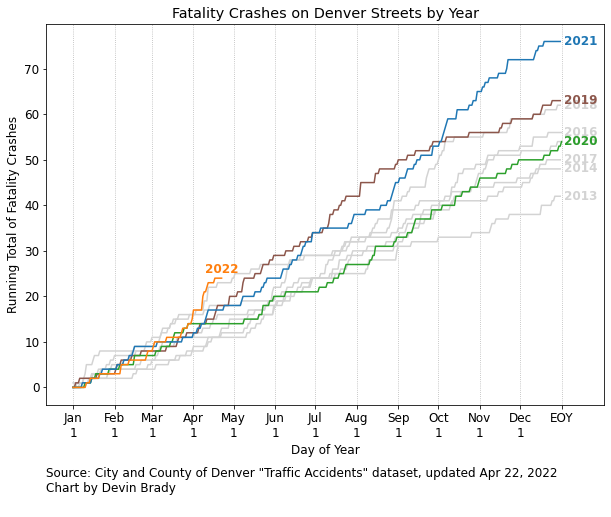

In [7]:
# Make the chart

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(figsize=(10,7))

max_x_value = 380
plt.plot(range(0, max_x_value), [1] * max_x_value, alpha=0)

for year in sorted(df.crash_year.unique()):
    if year == 2019:
        color = 'tab:brown'
    elif year == 2020:
        color = 'tab:green'
    elif year == 2021:
        color = 'tab:blue'
    elif year == 2022:
        color = 'tab:orange'
    else:
        color = 'lightgray'
        
    plt.plot(running_total_crashes[year], label=year, color=color)
    
    # trendline
    # plt.plot([0, days_in_year[year]], [0, fatality_crashes_by_year[year]], color=color, linestyle=':')
    
    if year == 2022:
        annotation_x = max_day_of_year
        annotation_y = max(running_total_crashes[year]) + 2
    else:
        annotation_x = max_x_value
        annotation_y = max(running_total_crashes[year])

    ax.annotate(
        xy=(annotation_x, annotation_y)
        , text=year
        , color=color
        , fontweight='bold'
        , horizontalalignment='center'
        , verticalalignment='center'
    )

    
plt.xticks(ticks=first_of_month['day_of_year'], labels=first_of_month['label'])
plt.grid(axis='x', linestyle=':')

citation = f"""
Source: City and County of Denver "Traffic Accidents" dataset, updated {df.reported_date.max().strftime('%b %-d, %Y')}
Chart by Devin Brady
"""

ax.annotate(xy=(0, -0.2), text=citation, xycoords='axes fraction', ha='left', va='center')
plt.xlabel('Day of Year')
plt.ylabel('Running Total of Fatality Crashes')
plt.title('Fatality Crashes on Denver Streets by Year')
_ = plt.savefig('fatality_crashes_by_year.png', transparent=False, facecolor='white', bbox_inches='tight')

## Counts

In [8]:
fatality_crashes_by_year = df.groupby('crash_year').fatality.sum()
fatality_crashes_by_year

crash_year
2013    42
2014    48
2015    54
2016    56
2017    50
2018    62
2019    63
2020    54
2021    76
2022    24
Name: fatality, dtype: int64

In [9]:
# Fatality crashes as of this day in the year
running_total_crashes.loc[max_day_of_year]

crash_year
2013    11.0
2014    18.0
2015    23.0
2016    12.0
2017    16.0
2018    13.0
2019    18.0
2020    14.0
2021    17.0
2022    24.0
Name: 112, dtype: float64

In [10]:
days_per_fatality_crash = days_in_year / fatality_crashes_by_year
days_per_fatality_crash

2013    8.690476
2014    7.604167
2015    6.759259
2016    6.535714
2017    7.300000
2018    5.887097
2019    5.793651
2020    6.777778
2021    4.802632
2022    4.666667
dtype: float64

In [11]:
fatality_crash_per_day = fatality_crashes_by_year / days_in_year
fatality_crash_per_day

crash_year
2013    0.115068
2014    0.131507
2015    0.147945
2016    0.153005
2017    0.136986
2018    0.169863
2019    0.172603
2020    0.147541
2021    0.208219
2022    0.214286
dtype: float64

In [12]:
# Fatality crashes per year, current year projected
projected_fatality_crashes_by_year = fatality_crashes_by_year.astype(float).copy()
this_year = df.reported_date.max().year
projected_fatality_crashes_by_year[this_year] = fatality_crash_per_day[this_year] * pd.Timestamp(this_year, 12, 31).dayofyear
projected_fatality_crashes_by_year

crash_year
2013    42.000000
2014    48.000000
2015    54.000000
2016    56.000000
2017    50.000000
2018    62.000000
2019    63.000000
2020    54.000000
2021    76.000000
2022    78.214286
Name: fatality, dtype: float64

## Lists

In [13]:
f = cda.recent_fatality_crashes(df)

               incident_address          neighborhood_id       crash_time_str  days_between  days_ago
       I25 HWYNB / W COLFAX AVE             Lincoln Park  Sun Feb 6, 11:24 AM      0.388889 77.860252
     N WILLIAMS ST / E 31ST AVE                 Whittier  Sat Feb 12, 2:24 PM      6.125000 71.735252
        E 69TH AVE / N TOWER RD                      DIA  Fri Feb 25, 8:17 PM     13.245139 58.490113
S SANTA FE DR / W LOUISIANA AVE                 Overland  Sat Feb 26, 3:18 AM      0.292361 58.197752
     LEETSDALE DR / S MONACO ST Washington Virginia Vale  Wed Mar 2, 10:25 PM      4.796528 53.401224
          I25 HWYSB / W 8TH AVE             Lincoln Park  Thu Mar 3, 11:21 PM      1.038889 52.362335
      I25 HWYNB / W ALAMEDA AVE                    Baker  Sat Mar 12, 3:32 AM      8.174306 44.188030
         I25 HWYSB / W 13TH AVE             Lincoln Park  Wed Mar 23, 1:01 AM     10.895139 33.334558
      W 5TH AVE / N KALAMATH ST                    Baker Thu Mar 24, 10:55 AM     